In [4]:
import os
import glob
import torch
import pandas as pd
import numpy as np
from pathlib import Path

# add code directory to path
import sys
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from functools import partial
from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from torch_perturb.perturbations import perturbed
from torch_models import torch_bpr_uncurried, deterministic_bpr
from matplotlib import pyplot as plt


2025-01-22 15:28:00.777998: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 15:28:00.828559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 15:28:00.828589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 15:28:00.829822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 15:28:00.838969: I tensorflow/core/platform/cpu_feature_guar

In [5]:

def load_data(data_dir, bird=False):
    """Load and process training, validation, and test data."""

    if bird:
        bird = 'bird_'
    else:
        bird =  ''
    # Load data
    train_X_df = pd.read_csv(os.path.join(data_dir, f'{bird}train_x.csv'), index_col=[0,1])
    train_Y_df = pd.read_csv(os.path.join(data_dir, f'{bird}train_y.csv'), index_col=[0,1])
    val_X_df = pd.read_csv(os.path.join(data_dir, f'{bird}valid_x.csv'), index_col=[0,1])
    val_Y_df = pd.read_csv(os.path.join(data_dir, f'{bird}valid_y.csv'), index_col=[0,1])
    test_X_df = pd.read_csv(os.path.join(data_dir, f'{bird}test_x.csv'), index_col=[0,1])
    test_Y_df = pd.read_csv(os.path.join(data_dir, f'{bird}test_y.csv'), index_col=[0,1])
    
    def convert_df_to_3d_array(df):
        geoids = sorted(df.index.get_level_values('geoid').unique())
        timesteps = sorted(df.index.get_level_values('timestep').unique())
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        num_timesteps = len(timesteps)
        num_locations = len(geoids)
        num_features = len(df.columns)
        X = np.zeros((num_timesteps, num_locations, num_features))
        
        for (geoid, timestep), row in df.iterrows():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            X[t_idx, g_idx, :] = row.values
            
        return X, geoids, timesteps

    def convert_y_df_to_2d_array(y_df, geoids, timesteps):
        num_timesteps = len(timesteps)
        num_locations = len(geoids)
        y = np.zeros((num_timesteps, num_locations))
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        for (geoid, timestep), value in y_df.iloc[:, 0].items():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            y[t_idx, g_idx] = value
            
        return y

    # Process training data
    train_X, geoids, timesteps = convert_df_to_3d_array(train_X_df)#.drop(columns='timestep.1'))
    train_time = np.array([timesteps] * len(geoids)).T
    train_y = convert_y_df_to_2d_array(train_Y_df, geoids, timesteps)

    # Process validation data
    val_X, val_geoids, val_timesteps = convert_df_to_3d_array(val_X_df)#.drop(columns='timestep.1'))
    val_time = np.array([val_timesteps] * len(val_geoids)).T
    val_y = convert_y_df_to_2d_array(val_Y_df, val_geoids, val_timesteps)

    # Process test data
    test_X, test_geoids, test_timesteps = convert_df_to_3d_array(test_X_df)#.drop(columns='timestep.1'))
    test_time = np.array([test_timesteps] * len(test_geoids)).T
    test_y = convert_y_df_to_2d_array(test_Y_df, test_geoids, test_timesteps)

    return {
        'train': (torch.tensor(train_X, dtype=torch.float32), 
                 torch.tensor(train_time, dtype=torch.float32),
                 torch.tensor(train_y, dtype=torch.float32)),
        'val': (torch.tensor(val_X, dtype=torch.float32),
               torch.tensor(val_time, dtype=torch.float32),
               torch.tensor(val_y, dtype=torch.float32)),
        'test': (torch.tensor(test_X, dtype=torch.float32),
                torch.tensor(test_time, dtype=torch.float32),
                torch.tensor(test_y, dtype=torch.float32))
    }

In [6]:
location = 'MA'

dirs = {'MA': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/long/MA', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/MA/'),
        'cook': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/cook', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/cook/'),}
data_dir, base_dir = dirs[location]

In [8]:
# Find all experiment directories
exp_dirs = glob.glob(os.path.join(base_dir, "K*"))

device = 'cuda'
K=100
data = load_data(data_dir,bird=False)

# Move data to device
val_data = tuple(x.to(device) for x in data['val'])
test_data = tuple(x.to(device) for x in data['test'])


num_ranking_samples = 1000
num_trials = 1000

In [10]:
data['train'][0].shape

torch.Size([9, 1620, 14])

In [13]:
train_X_df = pd.read_csv(os.path.join(data_dir, f'train_x.csv'), index_col=[0,1])

In [15]:
train_X_df.columns

Index(['deaths_sp_lag', 'lat', 'lon', 'timestep.1', 'theme_1_pc', 'theme_2_pc',
       'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'prev_deaths_05back',
       'prev_deaths_04back', 'prev_deaths_03back', 'prev_deaths_02back',
       'prev_deaths_01back'],
      dtype='object')

In [23]:
assert np.all(data['train'][0][-1,:,-2].numpy() ==  data['train'][2][-3].numpy())

In [17]:
data['train'][0][-1,:,-1]

tensor([0., 2., 0.,  ..., 0., 0., 0.])

In [19]:
 data['train'][2][-2]

tensor([0., 2., 0.,  ..., 0., 0., 0.])

(array([ 43.,  98., 232., 227., 177., 118.,  59.,  26.,  17.,   3.]),
 array([0.01515152, 0.05348485, 0.09181818, 0.13015151, 0.16848485,
        0.20681819, 0.24515152, 0.28348485, 0.32181817, 0.36015153,
        0.39848486]),
 <BarContainer object of 10 artists>)

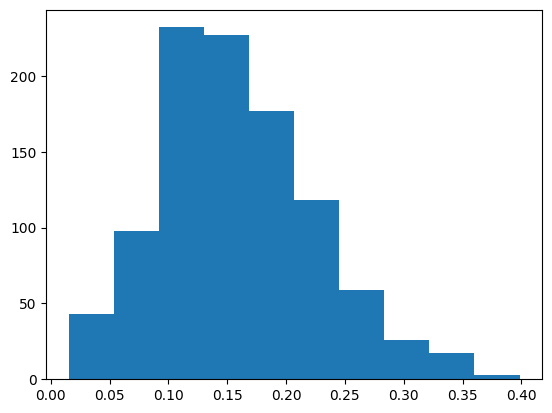

In [34]:

# get random data
torch.random.manual_seed(0)
# average over 1k trials
bprs = []
for trial in range(1000):
    bpr = deterministic_bpr(torch.rand(data['test'][2].shape),data['test'][2])
    bprs.append(bpr.mean())

plt.hist(bprs)


In [50]:
deterministic_bpr(torch.mean(data['train'][0][:,:,-2:],-1),data['train'][2])

tensor([0.1579, 0.1500, 0.1667, 0.4545, 0.1935, 0.4667, 0.5000, 0.4828, 0.3667])

In [ ]:
a